In [2]:
import pandas as pd

# Load the first CSV file
company_tweet_df = pd.read_csv('./Company_Tweet.csv')

tweet_df = pd.read_csv('./Tweet.csv')
# Display the column names for the first file
company_tweet_df.columns.tolist()
tweet_df.columns.tolist()

['tweet_id',
 'writer',
 'post_date',
 'body',
 'comment_num',
 'retweet_num',
 'like_num']

In [8]:

# Merge the dataframes on 'tweet_id'
merged_df = pd.merge(company_tweet_df, tweet_df, on='tweet_id', how='inner')
# Convert 'post_date' from epoch time to datetime format
merged_df['post_date'] = pd.to_datetime(merged_df['post_date'], unit='s')
merged_df['post_date'] = merged_df['post_date'].dt.date
# Display the first few rows to confirm the conversion
merged_df.head()

# Display the merged dataframe columns to verify
merged_df.columns.tolist(), merged_df.head()


(['tweet_id',
  'ticker_symbol',
  'writer',
  'post_date',
  'body',
  'comment_num',
  'retweet_num',
  'like_num'],
              tweet_id ticker_symbol      writer   post_date  \
 0  550803612197457920          AAPL  SentiQuant  2015-01-01   
 1  550803612197457920          AMZN  SentiQuant  2015-01-01   
 2  550803610825928706          AAPL  SentiQuant  2015-01-01   
 3  550803610825928706         GOOGL  SentiQuant  2015-01-01   
 4  550803610825928706          AMZN  SentiQuant  2015-01-01   
 
                                                 body  comment_num  \
 0  #TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...            0   
 1  #TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...            0   
 2  #SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...            0   
 3  #SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...            0   
 4  #SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...            0   
 
    retweet_num  like_num  
 0            0         1  
 1            0  

In [9]:
merged_df.to_csv('./new_Tweet.csv', index=False)


In [38]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# Assuming MODEL is already set to the path of your model
MODEL = "./results/checkpoint-500"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Load the comments and stock prices data
tweets_df = pd.read_csv('./new_Tweet.csv')
tweets_df = tweets_df[tweets_df['ticker_symbol'] == "AAPL"]
tweets_df = tweets_df[tweets_df['post_date'] >= '2018-03-29']
tweets_df = tweets_df[tweets_df['post_date'] <= '2018-09-31']
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


# Preprocess and predict sentiment for each comment
def get_sentiment(text):
    processed_text = preprocess(text)
    encoded_input = tokenizer(processed_text, return_tensors='pt')
    with torch.no_grad():  # This line ensures gradients are not computed
        output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores


In [39]:
tweets_df.count()

tweet_id         102482
ticker_symbol    102482
writer           101783
post_date        102482
body             102482
comment_num      102482
retweet_num      102482
like_num         102482
dtype: int64

In [40]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
# Check if CUDA is available and set the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Move the model to the device
model.to(device)
batch_size = 128
# Tokenize all comments
encoded_comments = tokenizer(list(tweets_df['body']), padding=True, truncation=True, return_tensors='pt')

# Create a TensorDataset and DataLoader
dataset = TensorDataset(encoded_comments['input_ids'], encoded_comments['attention_mask'])
dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=batch_size)

# Now, iterate over batches and make predictions using the GPU
model.eval()  # Set the model to evaluation mode
negative_scores = []
neutral_scores = []
positive_scores = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Evaluating", unit="batch"):
        input_ids, attention_mask = batch

        # Move the batch to the device (e.g., GPU or CPU)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Compute the logits
        outputs = model(input_ids, attention_mask=attention_mask)
        scores = outputs.logits.detach().cpu().numpy()  # Move the logits back to CPU
        scores = softmax(scores, axis=1)

        # Extend the lists with the individual scores
        negative_scores.extend(scores[:, 0])
        neutral_scores.extend(scores[:, 1])
        positive_scores.extend(scores[:, 2])

# Add the individual sentiment scores to the DataFrame
tweets_df['negative_sentiment'] = negative_scores
tweets_df['neutral_sentiment'] = neutral_scores
tweets_df['positive_sentiment'] = positive_scores


Using device: cuda:0


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Evaluating: 100%|██████████| 801/801 [21:28<00:00,  1.61s/batch]


In [4]:
tweets_df.count()

tweet_id              91284
ticker_symbol         91284
writer                90757
post_date             91284
body                  91284
comment_num           91284
retweet_num           91284
like_num              91284
negative_sentiment    91284
neutral_sentiment     91284
positive_sentiment    91284
dtype: int64

In [41]:
tweets_df = tweets_df.drop('comment_num',axis=1)
tweets_df = tweets_df.drop('retweet_num',axis=1)
tweets_df = tweets_df.drop('like_num',axis=1)
tweets_df = tweets_df.drop('writer',axis=1)
tweets_df = tweets_df.drop('body',axis=1)
tweets_df.to_csv('./APPLE18-03-29-18-09-31.csv', index=False)

In [4]:
import pandas as pd
apple_df = pd.read_csv('./APPLE18-03-29-18-09-31.csv')
df_sentiment_avg = apple_df.groupby('post_date')['positive_sentiment'].mean().reset_index()
df_sentiment_avg['Date'] = pd.to_datetime(df_sentiment_avg['post_date']).dt.date
df_sentiment_avg

,post_date,positive_sentiment,Date
0,2018-03-29,0.743039,2018-03-29
1,2018-03-30,0.766864,2018-03-30
2,2018-03-31,0.783549,2018-03-31
3,2018-04-01,0.799085,2018-04-01
4,2018-04-02,0.679271,2018-04-02
...,...,...,...
181,2018-09-26,0.807427,2018-09-26
182,2018-09-27,0.832644,2018-09-27
183,2018-09-28,0.810862,2018-09-28
184,2018-09-29,0.801368,2018-09-29


In [5]:
df_company_values = pd.read_csv('./CompanyValues.csv')
df_company_values = df_company_values[df_company_values['day_date']>= '2018-03-29']
df_company_values = df_company_values[df_company_values['day_date']<= '2018-09-30']
df_company_values = df_company_values[df_company_values['ticker_symbol'] == 'AAPL']
df_company_values['Date'] = pd.to_datetime(df_company_values['day_date']).dt.date
df_company_values

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,Date
418,AAPL,2018-09-28,225.74,22560440,224.79,225.84,224.020,2018-09-28
419,AAPL,2018-09-27,224.95,29729270,223.82,226.44,223.540,2018-09-27
420,AAPL,2018-09-26,220.42,23430370,221.00,223.75,219.760,2018-09-26
421,AAPL,2018-09-25,222.19,22811140,219.75,222.82,219.700,2018-09-25
422,AAPL,2018-09-24,220.79,27581270,216.82,221.26,216.630,2018-09-24
...,...,...,...,...,...,...,...,...
2938,AAPL,2018-09-16,223.84,31801970,225.75,226.84,222.522,2018-09-16
2939,AAPL,2018-09-22,217.66,95584080,220.78,221.36,217.290,2018-09-22
2940,AAPL,2018-09-23,217.66,95584080,220.78,221.36,217.290,2018-09-23
2941,AAPL,2018-09-29,225.74,22560440,224.79,225.84,224.020,2018-09-29


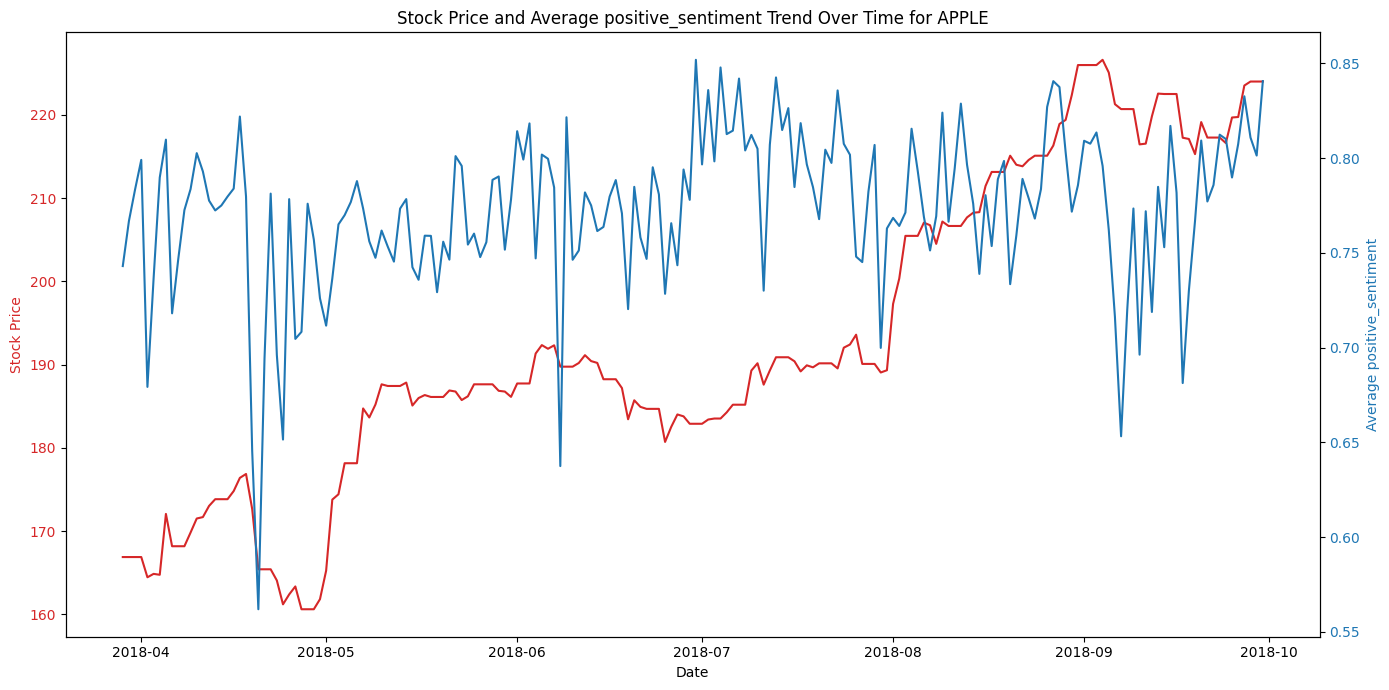

In [6]:
from matplotlib import pyplot as plt
merged_with_average_sentiment = pd.merge(df_company_values, df_sentiment_avg, on=['Date'])
merged_with_average_sentiment.set_index('Date', inplace=True)
merged_with_average_sentiment = merged_with_average_sentiment.sort_index()
# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the stock prices
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price', color=color)
ax1.plot(merged_with_average_sentiment.index, merged_with_average_sentiment['low_value'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the average positive sentiment score
color = 'tab:blue'
ax2.set_ylabel(f'Average positive_sentiment', color=color)
ax2.plot(merged_with_average_sentiment.index, merged_with_average_sentiment['positive_sentiment'], color=color, marker=' ')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title(f'Stock Price and Average positive_sentiment Trend Over Time for APPLE')
fig.tight_layout()

# Show the plot
plt.show()

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt






,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,post_date,positive_sentiment
Date,,,,,,,,,
2018-03-29,AAPL,2018-03-29,167.78,38116290,167.805,171.75,166.90,2018-03-29,0.743039
2018-03-30,AAPL,2018-03-30,167.78,38116290,167.805,171.75,166.90,2018-03-30,0.766864
2018-03-31,AAPL,2018-03-31,167.78,38116290,167.805,171.75,166.90,2018-03-31,0.783549
2018-04-01,AAPL,2018-04-01,167.78,38116290,167.805,171.75,166.90,2018-04-01,0.799085
2018-04-02,AAPL,2018-04-02,166.68,37425640,167.880,168.94,164.47,2018-04-02,0.679271
...,...,...,...,...,...,...,...,...,...
2018-09-26,AAPL,2018-09-26,220.42,23430370,221.000,223.75,219.76,2018-09-26,0.807427
2018-09-27,AAPL,2018-09-27,224.95,29729270,223.820,226.44,223.54,2018-09-27,0.832644
2018-09-28,AAPL,2018-09-28,225.74,22560440,224.790,225.84,224.02,2018-09-28,0.810862


In [22]:
# Assume we have complete daily data and find the last day of the previous n months
merged_df = merged_with_average_sentiment
n_months = 4  # Train using the data of the previous 9 months
window_size = 2
train_end_date = merged_df.index.min() + pd.DateOffset(months=n_months)
test_start_date = train_end_date + pd.DateOffset(days=-window_size)
# Create the training and test sets
train_data = merged_df[:train_end_date]
test_data = merged_df[test_start_date:]

input_feature = ['low_value','positive_sentiment']

# Data normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(merged_df[input_feature])  # Fit the scaler on all features
train_scaled = scaler.transform(train_data[input_feature])
test_scaled = scaler.transform(test_data[input_feature])

# Convert to PyTorch tensors
train_tensors = torch.tensor(train_scaled, dtype=torch.float32)
test_tensors = torch.tensor(test_scaled, dtype=torch.float32)


# Create data loaders
train_loader = DataLoader(train_tensors, batch_size=64, shuffle=False)
test_loader = DataLoader(test_tensors, batch_size=64, shuffle=False)




def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+1:i+tw+1, 0]  # Modify to select only 'Close' price as label
        inout_seq.append((train_seq, train_label))
    return inout_seq


train_inout_seq = create_inout_sequences(train_tensors, window_size)


# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=len(input_feature), hidden_layer_size=256, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions

# 实例化模型
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 训练模型
epochs = 150
for i in range(epochs):
    for seq,label in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        # single_loss = loss_function(y_pred, seq[-1])
        single_loss = loss_function(y_pred, label.unsqueeze(dim=1))

        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

C:\Users\guokaifeng\AppData\Local\Temp\ipykernel_10784\2644619719.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  train_data = merged_df[:train_end_date]
C:\Users\guokaifeng\AppData\Local\Temp\ipykernel_10784\2644619719.py:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  test_data = merged_df[test_start_date:]


epoch:   1 loss: 0.00838752
epoch:  26 loss: 0.00876225
epoch:  51 loss: 0.00050003
epoch:  76 loss: 0.00019231
epoch: 101 loss: 0.00016788
epoch: 126 loss: 0.00014902


C:\Users\guokaifeng\AppData\Local\Temp\ipykernel_10784\891413380.py:27: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  demo = test_data[offset_date:]
C:\Users\guokaifeng\AppData\Local\Temp\ipykernel_10784\891413380.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo['Predicted'] = test_pred_rescaled


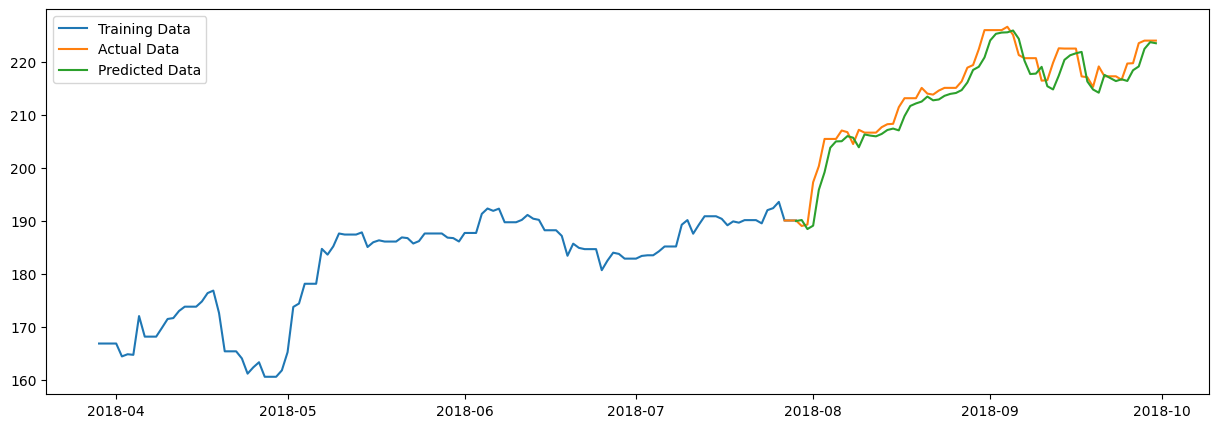

In [23]:
# Assuming the model has been trained and the test data is prepared, let's predict the test data.
model.eval()  # Set the model to evaluation mode
test_inout_seq = create_inout_sequences(test_tensors, window_size)
test_predictions = []
with torch.no_grad():
    for seq,label in test_inout_seq:
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        test_predictions.append(model(seq)[-1].detach().numpy())

# Flatten the predictions list
test_predictions = np.array(test_predictions).flatten()

# Since we only predict the 'Close' price, we need to construct the full array to inverse transform
# We'll pad the predictions with zeros for other features
test_pred_full = np.ones((len(test_predictions), len(input_feature)))  # 4 features as per the scaler fit
test_pred_full[:, 0] = test_predictions  # Insert predictions in the first column which corresponds to 'Close' price

# Now we inverse transform our predictions to be on the same scale as the original data
test_pred_rescaled = scaler.inverse_transform(test_pred_full)[:, 0]  # Inverse transform and select only 'Close' price

# We also need to inverse transform the test data
test_data_rescaled = scaler.inverse_transform(test_scaled)[:, 0]  # Select only 'Close' price

offset_date = test_data.index.min() + pd.DateOffset(days=window_size)
end_date = test_data.index.max() - pd.DateOffset(days=window_size)
demo = test_data[offset_date:]
# Add the predicted values to the test_data DataFrame
demo['Predicted'] = test_pred_rescaled

# Now let's plot the results
plt.figure(figsize=(15,5))
plt.plot(train_data['low_value'], label='Training Data')
plt.plot(test_data['low_value'], label='Actual Data')
plt.plot(demo.index, demo['Predicted'], label='Predicted Data')  # Use test_data index for x-axis
plt.legend()
plt.show()